# Welcome to the c-VEP analysis tutorial!

Code-modulated visual evoked potentials (c-VEP) are prominent in the
non-invasive brain-computer interface (BCI) literature for their ability to
enable reliable, high-speed control. These control signals arise from the
brain's exogenous responses to flickering stimuli that follow pseudorandom codes.

In this notebook, you will learn how to:
- Load electroencephalographic (EEG) signals from a c-VEP experiment.
- Plot the pseudorandom sequences that encode application commands.
- Calibrate the system using the reference processing pipeline.
- Plot the calibrated templates.
- Decode the selected commands during a free-spelling phase and evaluate performance metrics.

*Updated to the latest medusa-kernel (14 jul. 2025)*

***
## Our c-VEP-based paradigm

### Experiment briefing
In this tutorial, we will work with pre-recorded data from a user participating in a c-VEP experiment using the __[`c-VEP Speller`](https://www.medusabci.com/market/cvep_speller/)__ app from __[MEDUSA©](https://www.medusabci.com)__.

The objective of the experiment was to control a c-VEP-based speller composed of 16 alphanumeric commands (letters A to P). These commands were encoded using shifted versions of a pseudorandom binary code, with zeros represented by black flashes and ones by white flashes. The encoding utilized a 63-bit m-sequence with an optimal autocorrelation function.

During the calibration phase, the user focused on a command encoded with the original m-sequence across 6 runs, each consisting of 5 trials. Each trial included 10 cycles (repetitions of the same m-sequence). In the online phase, the user engaged in free-spelling with 32 trials (each with 10 cycles), selecting all possible commands sequentially twice. The EEG data were recorded from 16 active channels positioned at OZ, F3, FZ, F4, I1, I2, C3, CZ, C4, CPZ, P3, PZ, P4, PO7, POZ, and PO8, with a sampling rate of 256 Hz.


### Load calibration and test data
First, if you are using Google Colab, execute the following cell to install `medusa-kernel` and clone the GitHub repository to obtain the EEG recordings.

<div class="alert alert-block alert-danger">
Important: execute the following cell **only** if you're using Google Collab!
</div>


In [2]:
!pip install medusa-kernel
!git clone https://github.com/medusabci/medusa-tutorials.git

## Imports

Let's import the necessary modules for this notebook and define some useful functions.

In [3]:
# General imports
import glob
import numpy as np
import matplotlib.pyplot as plt

# Medusa imports
from medusa import meeg
from medusa import components
from medusa.bci.metrics import itr
from medusa.bci import cvep_spellers as cvep
from medusa.plots import head_plots

print('> Import successful!')

def trim_unfinished_trial(rec):
    """
        Trims the data of an unfinished trial by removing entries that exceed the last completed cycle.

        Parameters:
        rec (object): An object containing cvepspellerdata with attributes related to trial data.

        Returns:
        object: The input object with truncated data attributes for unfinished trials.
    """
    max_idx = np.max(rec.cvepspellerdata.cycle_idx)
    if max_idx != rec.cvepspellerdata.cycle_idx[-1]:
        last_idx = np.where(rec.cvepspellerdata.cycle_idx == max_idx)[0][-1] + 1
        for attr in ['cycle_idx', 'level_idx', 'matrix_idx', 'onsets', 'trial_idx', 'unit_idx']:
            setattr(rec.cvepspellerdata, attr, getattr(rec.cvepspellerdata, attr)[:last_idx])
    return rec
home_path = 'medusa-tutorials/'
print('> Auxiliary functions defined!')

> Import successful!
> Auxiliary functions defined!


Next, we'll load the calibration signals and compile them into a dataset. This ensures consistency across the signals,
maintaining uniform experimental conditions, e.g. the sampling rate.

In [4]:
def create_dataset(files_path):
    """
    Creates a CVEPSpellerDataset from multiple recording files.

    Parameters:
    files_path (list of str): A list of file paths to the recording files.

    Returns:
    CVEPSpellerDataset: A dataset containing all the processed recordings.
    """
    dataset = None
    for i, test_ in enumerate(files_path):
        rec = trim_unfinished_trial(components.Recording.load(test_))
        if dataset is None:
            dataset = cvep.CVEPSpellerDataset(
                channel_set=rec.eeg.channel_set,
                fs=rec.eeg.fs
            )
        dataset.add_recordings(rec)
    return dataset

# Load calibration data
print('> Loading calibration data...')
f_train = glob.glob(f"{home_path}cvep/*train*.cvep.bson")        # If you're
# in local, maybe you need to change this path
train_dataset = create_dataset(f_train)

# Display summary
print('   - Dataset created from %i recordings' % len(train_dataset.recordings))
print('   - Sampling rate of %.2f Hz' % train_dataset.fs)
print('   - %i EEG registered at positions %s' % (
    len(train_dataset.channel_set.l_cha),
    ', '.join(train_dataset.channel_set.l_cha)
))

> Loading calibration data...
   - Dataset created from 6 recordings
   - Sampling rate of 256.00 Hz
   - 16 EEG registered at positions OZ, F3, FZ, F4, I1, I2, C3, CZ, C4, CPZ, P3, PZ, P4, PO7, POZ, PO8


### Plot pseudorandom m-sequences

After loading the EEG signals for model calibration, we can visualize the m-sequence that the user focused on during the calibration process.

This sequence can either be extracted directly from the training dataset or regenerated using a Linear Feedback Shift Register (LFSR), as long as the necessary parameters are available:
   - `Base`: The number of levels in the output m-sequence (e.g., for binary codes, the base is 2).
   - `Order`: The polynomial order.
   - `Polynomial`: The primitive polynomial over the Galois Field `GF(base^order)` used to generate the m-sequence.

In this case, we are working with a binary m-sequence `GF(2^6)`. 



<div class="alert alert-block alert-info">
For more detailed information on the generation of these codes, refer to:

*Martínez-Cagigal, V., Santamaría-Vázquez, E., Pérez-Velasco, S., Marcos-Martínez, D., Moreno-Calderón, S., & Hornero, R. (2023). Non-binary m-sequences for more comfortable brain–computer interfaces based on c-VEPs. Expert Systems with Applications, 232, 120815. DOI: __[https://doi.org/10.1016/j.eswa.2023.120815](https://doi.org/10.1016/j.eswa.2023.120815)__*
</div>



In [5]:
# To get the code, we can extract it from the unique command displayed
cal_code = train_dataset.recordings[0].cvepspellerdata.commands_info[0]['0']['sequence']

# Or we can generate the code again using the LFSR function
poly = [0, 0, 0, 0, 1, 1]
base = 2
order = 6
cal_code = cvep.LFSR(poly, base=base).sequence

Let's plot the code in the time domain, highlighting the encoding colors (black and white in this case) along with the corresponding temporal samples.

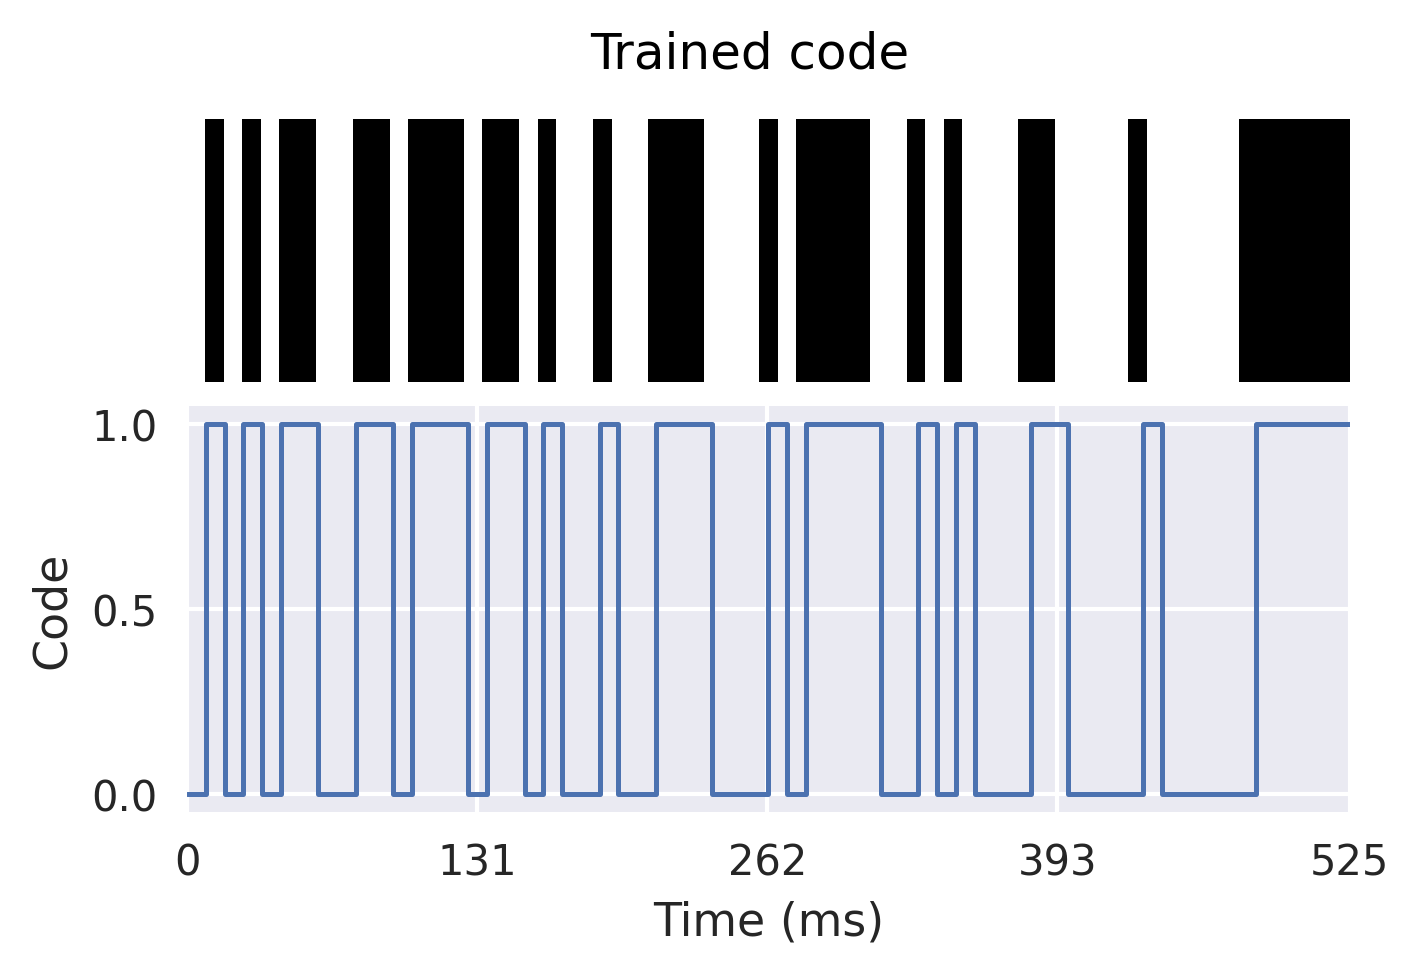

In [6]:
def create_abrupt_changes_in_code(seq, monitor_rate):
    """
    Adjusts a sequence to account for abrupt changes by duplicating values at points of change and
    calculates corresponding time samples based on the provided monitor rate.

    Parameters:
    seq (list): The original sequence of values to be processed.
    monitor_rate (float): The monitor refresh rate.

    Returns:
    tuple: A tuple containing two lists:
           - t_sam (list): The adjusted time samples corresponding to the sequence.
           - a_seq (list): The modified sequence with abrupt changes accounted for.
    """
    times = np.linspace(0, 1000 * len(cal_code) / monitor_rate, len(seq)).tolist()
    t_sam, a_seq = [times[0]], [seq[0]]
    for i in range(1, len(seq)):
        if seq[i] != seq[i - 1]:
            a_seq.append(seq[i - 1])
            t_sam.append(times[i])
        a_seq.append(seq[i])
        t_sam.append(times[i])
    return t_sam, a_seq

# Plot the code
fig = plt.figure(figsize=(5, 3), dpi=300)
gs = fig.add_gridspec(5, 3)
with plt.style.context('seaborn-v0_8'):
    # Plot encoding colors (black and white code)
    im_code = np.array(cal_code).reshape(-1, 1).T
    ax1 = fig.add_subplot(gs[0:2, :])
    ax1.imshow(im_code, aspect='auto')
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.axis('off')

    # Plot code in time
    ax2 = fig.add_subplot(gs[2:5, :])
    monitor_rate = train_dataset.recordings[0].cvepspellerdata.fps_resolution
    t_, seq_ = create_abrupt_changes_in_code(seq=cal_code, monitor_rate=monitor_rate)
    ax2.plot(t_, seq_, linewidth=1.2)
    ax2.set_xlim((0, t_[-1]))
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Code')
    ax2.set_xticks(np.linspace(0, t_[-1], 5).astype(int))
plt.suptitle('Trained code')
plt.show()


## Calibration stage
The next step is to train a model using the calibration recordings. In this process, signal processing follows the reference processing, which involves a simple bandpass filtering and spatial filtering using Canonical Correlation Analysis (CCA).

<div class="alert alert-block alert-info">
For more detailed information on this reference processing approach, please refer to:

*Martínez-Cagigal, V., Thielen, J., Santamaria-Vazquez, E., Pérez-Velasco, S., Desain, P., & Hornero, R. (2021). Brain–computer interfaces based on code-modulated visual evoked potentials (c-VEP): A literature review. Journal of Neural Engineering, 18(6), 061002. DOI: __[https://doi.org/10.1088/1741-2552/ac38cf](https://doi.org/10.1088/1741-2552/ac38cf)__*
</div>



### Train the model
To train the model, simply instantiate the `CVEPModelCircularShifting` class and call the `fit_dataset` function. This function also supports more advanced pipelines, such as filter banks or specific artifact rejection methods. However, in this tutorial, we'll keep things simple by using a unique 7-order infinite impulse response (IIR) bandpass filter set between 1 and 60 Hz.

It’s important to note that the filter's high cutoff is set to half the monitor rate (i.e., the rate at which the code is displayed on the monitor), as the highest frequency component of the code is 60 Hz, which corresponds to a constant flickering pattern of `01010101`...


In [7]:
# Calibration using BPF filtering and CCA
print('> Training the model...')
model = cvep.CVEPModelCircularShifting(bpf=[[7, (1.0, 60.0)]])
cal_info = model.fit_dataset(train_dataset)
len_epoch_ms = cal_info['len_epoch_ms']
print('   - Calibrated %i code(s)' % len(cal_info['sequences']))
print('   - Monitor rate of %.2f Hz' % cal_info['fps_resolution'])
print('   - Code length of %.2f ms' % cal_info['len_epoch_ms'])


> Training the model...


Creating templates: 100%|██████████| 63/63 [00:00<00:00, 2123.97it/s]

   - Calibrated 1 code(s)
   - Monitor rate of 120.00 Hz
   - Code length of 525.00 ms


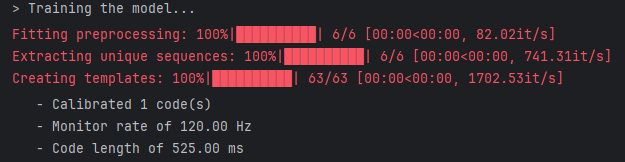### Plot the calibrated templates
During the calibration process, a CCA instance was trained as a spatial filter.
This filter projects the 16 channels onto a single temporal dimension, maximizing the correlation between the
single-trial brain responses to the code and the temporally averaged epoch of these responses (which
reflects the components of the event-related potential associated with the flickering code).

Using this spatial filter, the model generates a single-dimensional vector, known as the "main template",
which aggregates information from all channels. This template represents the projected response to the
original code. Additionally, our signal processing pipeline has stored all possible temporal shifts of
this template, which will be crucial for decoding the commands the user is focusing on during the online stage.

Let's plot this main template by accessing the trained code:

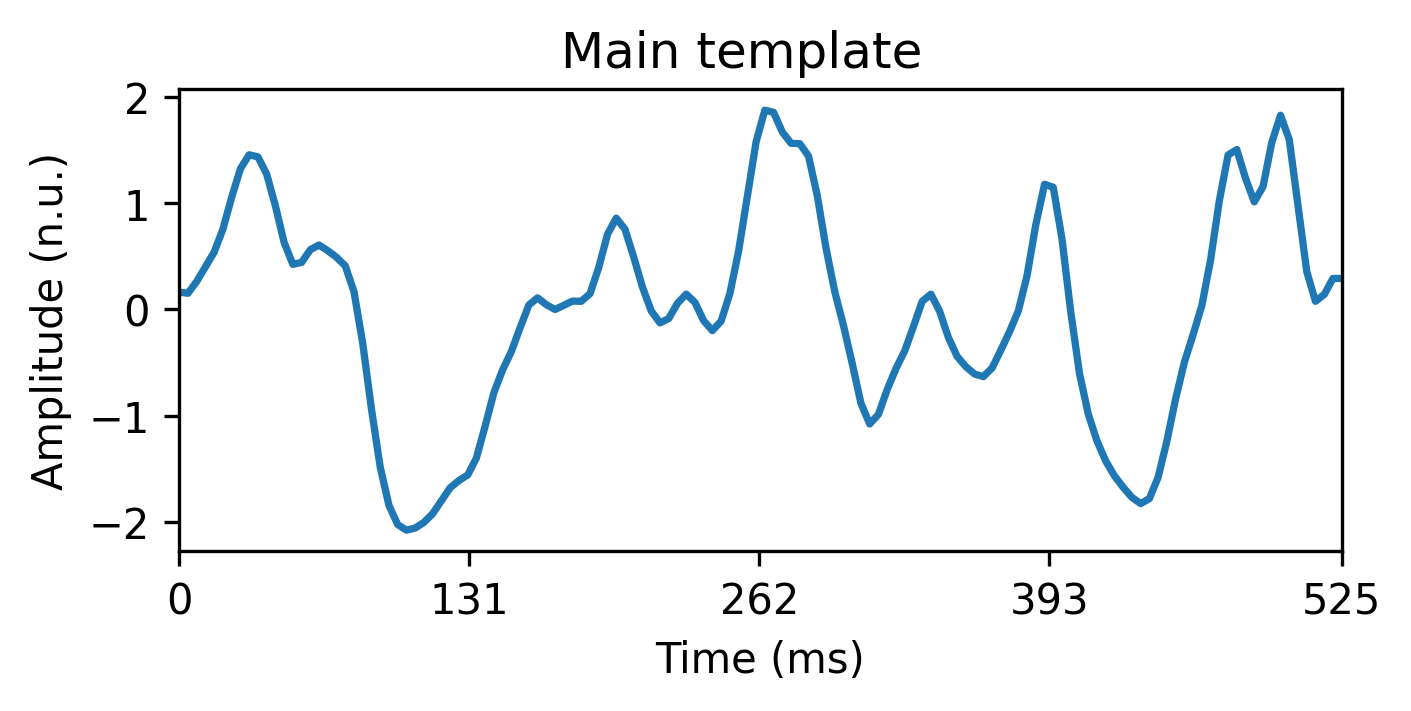

In [8]:
# Plot the main template
cca = cal_info['sequences'][tuple(cal_code)][0]
main_template = cca['templates'][tuple(cal_code)]
fig = plt.figure(figsize=(5, 2), dpi=300)
ax = fig.add_subplot(111)
with plt.style.context('seaborn-v0_8'):
    t_template = np.linspace(0, cal_info['len_epoch_ms'], len(main_template))
    ax.plot(t_template, main_template)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (n.u.)')
    ax.set_xlim((0, t_[-1]))
    ax.set_xticks(np.linspace(0, t_template[-1], 5).astype(int))
plt.suptitle('Main template')
plt.show()

As mentioned earlier, the trained CCA acts as a spatial filter, assigning different weights
to each channel based on their importance. We can visualize these weights using a topographic
head plot with the `TopographicPlot` class available in `medusa-kernel`:

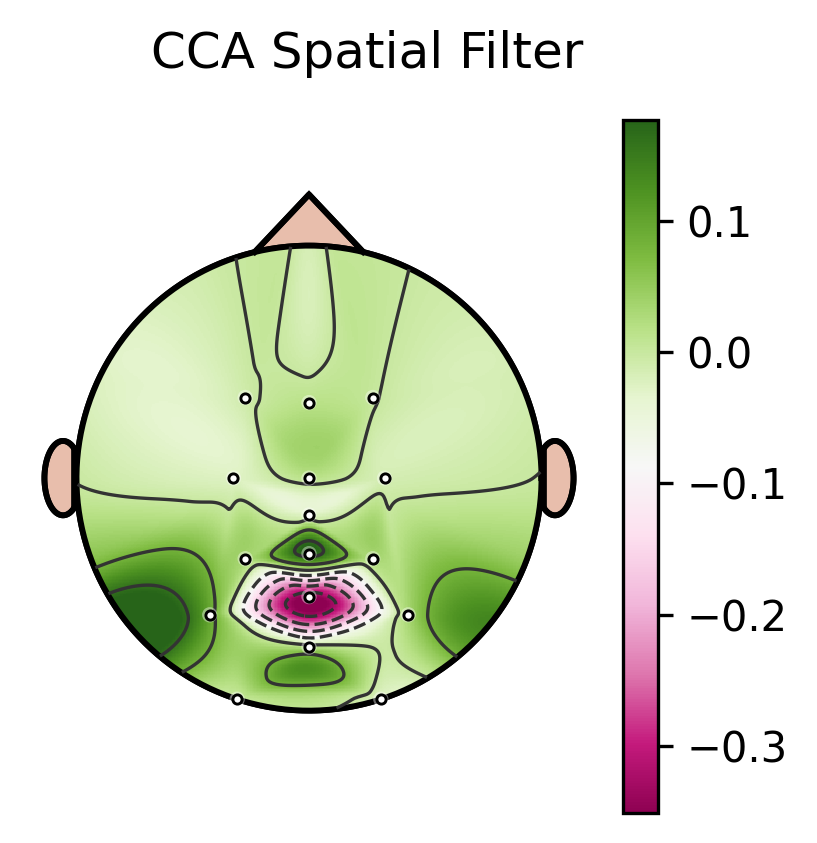

In [9]:
# Get the spatial filter
spatial_filter = cca['cca'].wy[:, 0]

# Plot the values of the filter over each channel
fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(111)
t_plot = head_plots.TopographicPlot(
    axes=ax,
    channel_set=train_dataset.channel_set,
    head_radius=1,
    extra_radius=0,
    cmap='PiYG',
    plot_channel_labels=False,
    head_line_width=1.4
)
t_plot.update(values=spatial_filter)
cbar = plt.colorbar(t_plot.plot_handles['color-mesh'])
plt.suptitle('CCA Spatial Filter')
plt.show()


## Decoding stage
Once the model is trained, we are ready to perform online decoding and evaluate its performance.

First, we need to load the test recordings along with the true labels, which represent the commands the user was focusing on during this stage.

In [10]:
# Load the test dataset
print('> Loading test data...')
test_path = f"{home_path}cvep/*test*.cvep.bson"
f_test = glob.glob(test_path)        # If you're in local, maybe you need to change this path
test_dataset = create_dataset(f_test)

# Load the true labels
labels_path = f"{home_path}cvep/cvep_labels.txt"
with open(labels_path, 'r') as file:        # If you're in local, maybe you need to change this path
    true_labels = file.read()

# Display summary
print('   - Test dataset created from %i recordings' % len(test_dataset.recordings))
print('   - Sampling rate of %.2f Hz' % test_dataset.fs)
print('   - %i EEG registered at positions %s' % (
    len(test_dataset.channel_set.l_cha),
    ', '.join(test_dataset.channel_set.l_cha)
))
print('   - True labels are: %s' % true_labels)

> Loading test data...
   - Test dataset created from 2 recordings
   - Sampling rate of 256.00 Hz
   - 16 EEG registered at positions OZ, F3, FZ, F4, I1, I2, C3, CZ, C4, CPZ, P3, PZ, P4, PO7, POZ, PO8
   - True labels are: ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP


Next, let's predict the selected commands using our trained model. To do this, simply call the `predict_dataset` function on the model instance:

In [11]:
# Decode the test set
print('> Decoding the test dataset...')
decoding = model.predict_dataset(test_dataset)
raw_result = ''.join(decoding['spell_result'])

> Decoding the test dataset...


Predicting dataset: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


We can also visualize the temporarily shifted versions of the code that are
encoded for each test command:


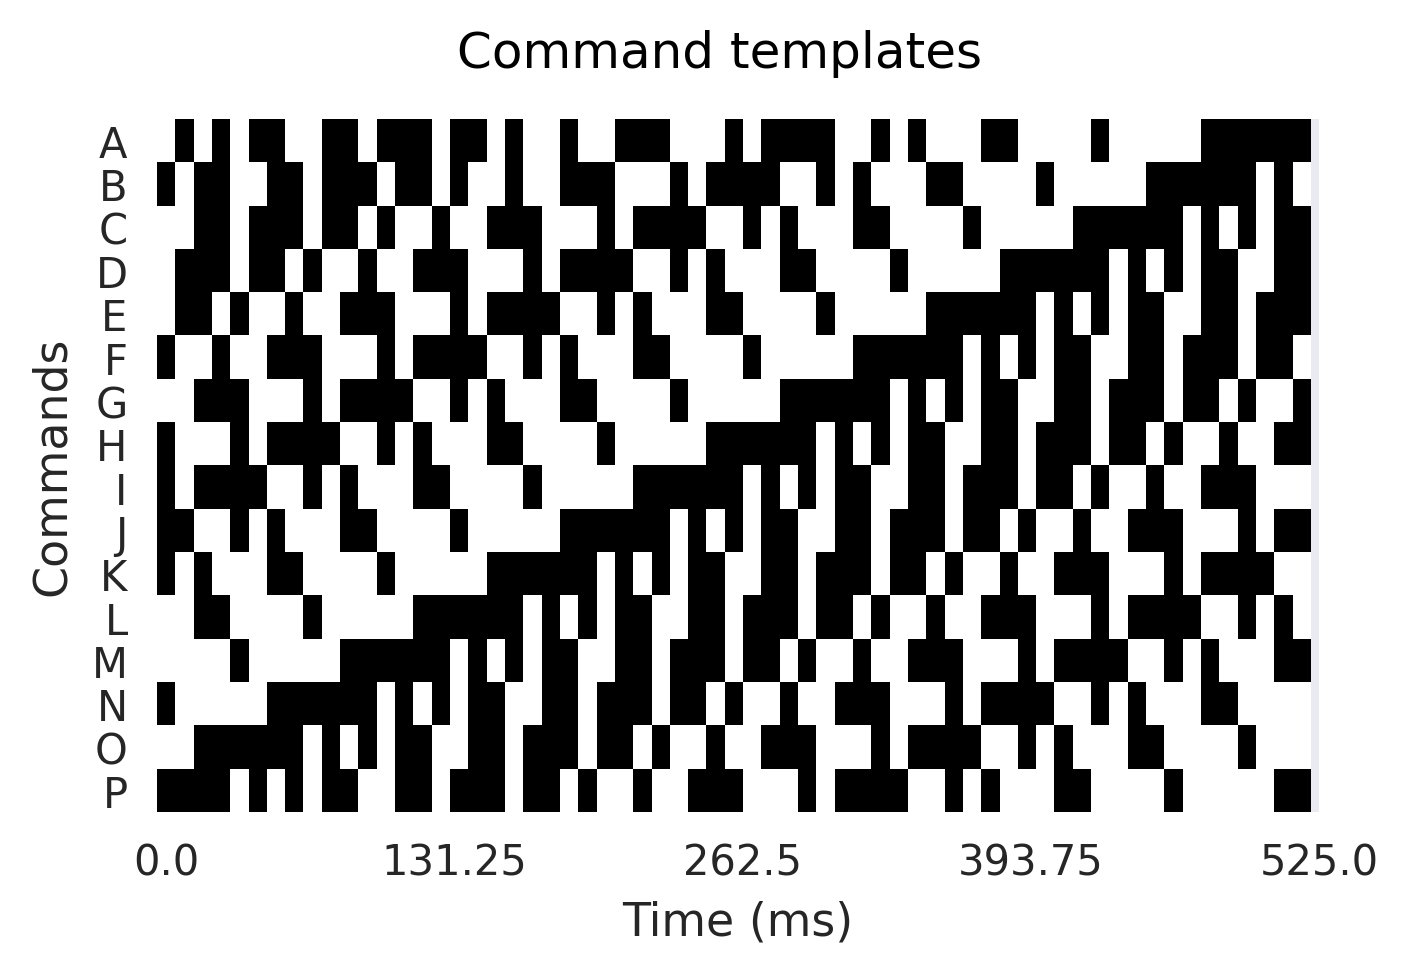

In [12]:
# Plot the codes
fig = plt.figure(figsize=(5, 3), dpi=300)
gs = fig.add_gridspec(5, 3)
with plt.style.context('seaborn-v0_8'):

    im_code = list()
    labels = list()
    for i in range(16):
        code = test_dataset.recordings[0].cvepspellerdata.commands_info[0][str(i)]['sequence']
        im_code.append(code)
        labels.append(test_dataset.recordings[0].cvepspellerdata
                      .commands_info[0][str(i)]['label'])
    im_code = np.array(im_code)

    ax = fig.add_subplot(111)
    ax.imshow(im_code, aspect='auto')
    ax.set_yticks(np.arange(0, 16))
    ax.set_yticklabels(labels)
    ax.set_xticks(np.linspace(0, im_code.shape[1], 5))
    ax.set_xticklabels(np.linspace(0, len_epoch_ms, 5))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Commands')
    ax.grid(False)
plt.suptitle('Command templates')
plt.show()

### Show performance metrics
The decoded commands are stored in the variable `decoding`, which includes:
- `spell_result`: Contains the decoded command labels obtained using the maximum number of cycles (10 cycles in this case).
- `spell_result_per_cycle`: Contains the output command labels for each trial, considering different numbers of cycles.
- `items_by_no_cycle`: Stores the sorted command objects for each trial and each number of cycles, ordered by correlation.

In this analysis, we will focus on `spell_result_per_cycle` to assess the accuracy, trial duration, and information transfer rate (ITR) for each stimulation cycle (i.e., code repetition).

   - Accuracy per cycles
      * Cycle 1 (0.53 s/trial, ITR of 58.03 bpm): 34.38% (APIJOPPPPJHPONOPPAPJEOGOPJOPGNOP)
      * Cycle 2 (1.05 s/trial, ITR of 169.60 bpm): 87.50% (AICDEFGHIJKPMNOPABCJEPGHIJKLMNOP)
      * Cycle 3 (1.57 s/trial, ITR of 152.38 bpm): 100.00% (ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP)
      * Cycle 4 (2.10 s/trial, ITR of 114.29 bpm): 100.00% (ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP)
      * Cycle 5 (2.62 s/trial, ITR of 91.43 bpm): 100.00% (ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP)
      * Cycle 6 (3.15 s/trial, ITR of 76.19 bpm): 100.00% (ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP)
      * Cycle 7 (3.67 s/trial, ITR of 65.31 bpm): 100.00% (ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP)
      * Cycle 8 (4.20 s/trial, ITR of 57.14 bpm): 100.00% (ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP)
      * Cycle 9 (4.72 s/trial, ITR of 50.79 bpm): 100.00% (ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP)
      * Cycle 10 (5.25 s/trial, ITR of 45.71 bpm): 100.00% (ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP)


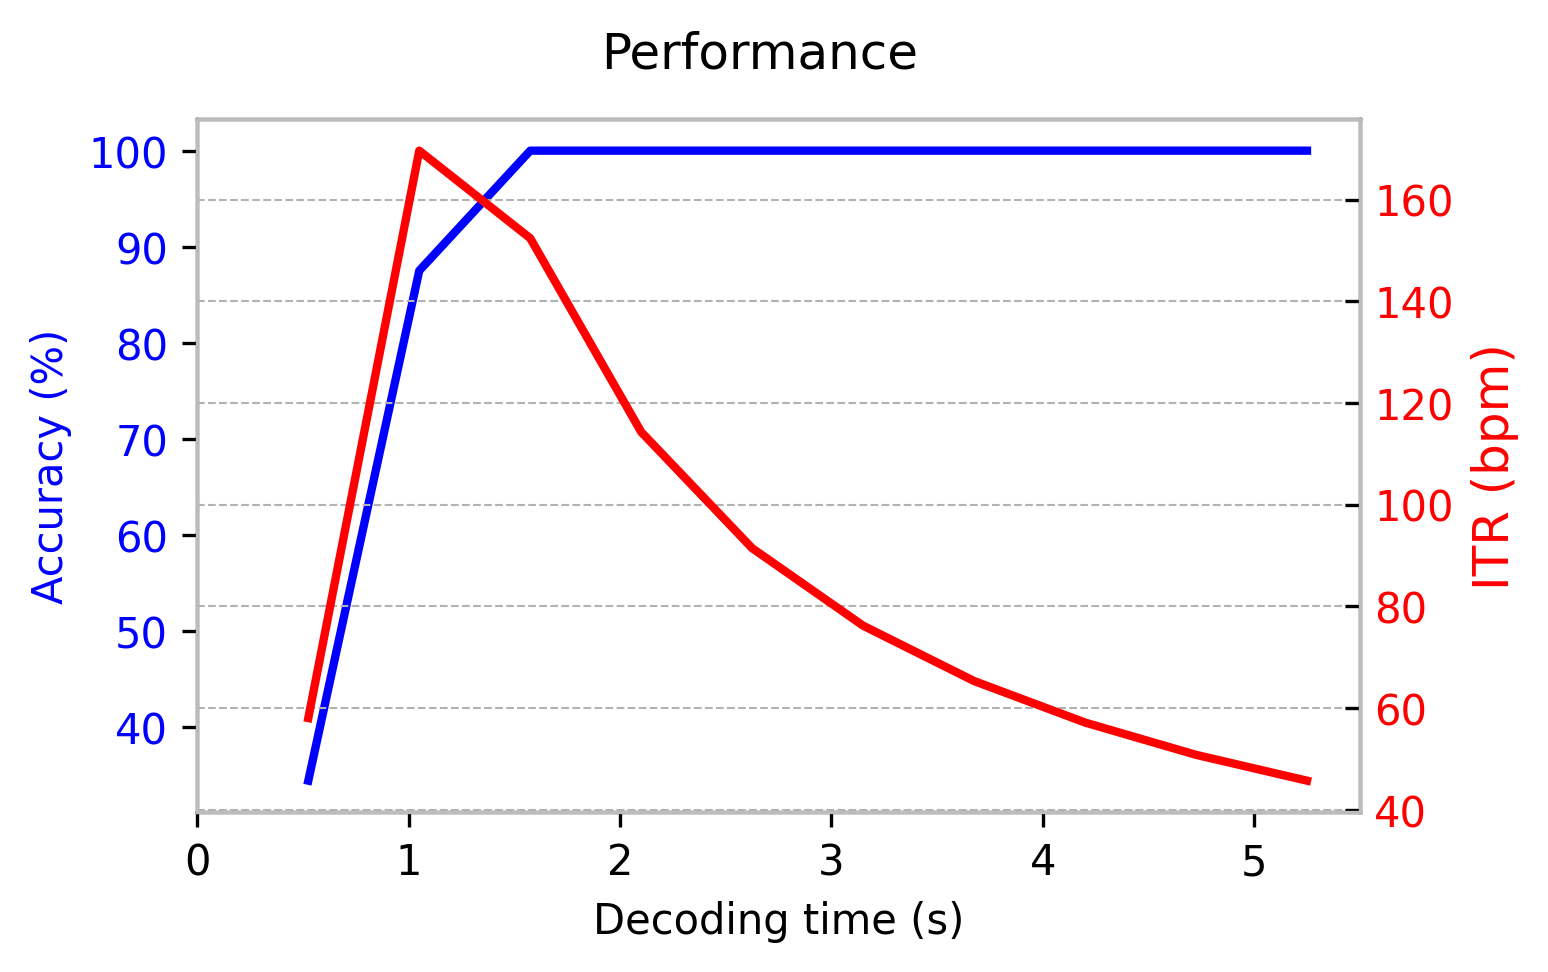

In [15]:
# Get the accuracy per cycles
counters = [0 for i in range(10)]
spelled = ['' for j in range(10)]
accuracy = None
for trial_idx in range(len(true_labels)):
    trial_ = decoding['spell_result_per_cycle'][trial_idx]
    for cycle_idx in range(10):
        spelled[cycle_idx] += trial_[cycle_idx]
        if trial_[cycle_idx] == true_labels[trial_idx]:
            counters[cycle_idx] += 1
accuracy = 100 * np.array(counters) / len(true_labels)
print("   - Accuracy per cycles")
itrs = list()
for cycle_idx in range(len(accuracy)):
    # Compute the duration of the trial in seconds
    online_secs = (cycle_idx + 1) * len_epoch_ms / 1000

    # Compute the ITR
    selections_per_min = 60 / online_secs
    curr_itr = itr(accuracy=accuracy[cycle_idx]/100,
                   n_commands=16,
                   selections_per_min=selections_per_min)
    itrs.append(curr_itr)

    # Display data
    print("      * Cycle %i (%.2f s/trial, ITR of %.2f bpm): %.2f%% (%s)" %
          (cycle_idx + 1, online_secs, curr_itr, accuracy[cycle_idx], spelled[cycle_idx])
    )

# Plot
fig = plt.figure(figsize=(5, 3), dpi=300)
ax = fig.add_subplot(111)
time = np.linspace(0, len_epoch_ms*10/1000, len(accuracy) + 1)[1:]
with plt.style.context('bmh'):
    ax.plot(time, accuracy, color='b')
    ax.set_xlabel('Decoding time (s)')
    ax.set_ylabel('Accuracy (%)', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax.set_xlim(0, 550)
    ax2 = ax.twinx()
    ax2.plot(time, itrs, color='r')
    ax2.set_ylabel("ITR (bpm)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_xlim(0, 5.5)
plt.suptitle('Performance')
plt.show()

As shown, this user demonstrates outstanding performance with 100% accuracy and an information transfer rate (ITR) of 152.38 bits per minute at the third cycle, corresponding to 1.57 seconds per selection.


## Conclusion
In this tutorial, we have successfully walked through the process of analyzing code-modulated visual evoked potentials (c-VEPs) for brain-computer interface (BCI) applications. We began by loading and calibrating EEG signals from a c-VEP experiment, then visualized the pseudorandom sequences used for encoding commands. The calibration process was carried out using a reference pipeline that involved bandpass filtering and Canonical Correlation Analysis (CCA) to enhance signal quality.

Following calibration, we visualized the main template generated by the model, which serves as a critical component for decoding. With the model trained, we proceeded to decode test recordings and evaluate the performance of our BCI system.

Our analysis demonstrated that the user achieved exceptional performance with 100% accuracy and an impressive information transfer rate (ITR) of 152.38 bits per minute at the third cycle, which corresponds to a selection time of 1.57 seconds. This result underscores the effectiveness of the c-VEP approach in achieving high-speed and reliable control in BCI systems.

Overall, this tutorial provides a comprehensive overview of the c-VEP analysis process, from data loading and calibration to decoding and performance evaluation. The techniques and methods illustrated here form a solid foundation for further exploration and development of c-VEP-based BCIs.

### To know more
If you're interested in exploring more about c-VEPs and their application in non-invasive BCIs, we recommend the following resources:
1. `General information about c-VEP`: Martínez-Cagigal, V., Thielen, J., Santamaria-Vazquez, E., Pérez-Velasco, S., Desain, P., & Hornero, R. (2021). Brain–computer interfaces based on code-modulated visual evoked potentials (c-VEP): A literature review. Journal of Neural Engineering, 18(6), 061002. DOI: __[https://doi.org/10.1088/1741-2552/ac38cf](https://doi.org/10.1088/1741-2552/ac38cf)__
2. `Non-binary codes to improve user convenience`: Martínez-Cagigal, V., Santamaría-Vázquez, E., Pérez-Velasco, S., Marcos-Martínez, D., Moreno-Calderón, S., & Hornero, R. (2023). Non-binary m-sequences for more comfortable brain–computer interfaces based on c-VEPs. Expert Systems with Applications, 232, 120815. DOI: __[https://doi.org/10.1016/j.eswa.2023.120815](https://doi.org/10.1016/j.eswa.2023.120815)__
3. `Bit-wise decoding using deep learning`: Nagel, S., & Spüler, M. (2019). World’s fastest brain-computer interface: combining EEG2Code with deep learning. PloS one, 14(9), e0221909. DOI:__[https://doi.org/10.1371/journal.pone.0221909](https://doi.org/10.1371/journal.pone.0221909)__
4. `Towards plug-ang-play calibration`: Thielen, J., Marsman, P., Farquhar, J., & Desain, P. (2021). From full calibration to zero training for a code-modulated visual evoked potentials for brain–computer interface. Journal of Neural Engineering, 18(5), 056007. DOI: __[https://doi.org/10.1088/1741-2552/abecef](https://doi.org/10.1088/1741-2552/abecef)__ 

For conducting c-VEP experiments, consider the following free-to-use applications within the MEDUSA© ecosystem:
1. __[`c-VEP Speller`](https://www.medusabci.com/market/cvep_speller/)__: This application provides a fundamental c-VEP speller based on the circular shifting paradigm, enabling the development of high-speed and reliable BCIs for communication and control by encoding commands using shifted versions of pseudorandom binary codes.
2. __[`P-ary c-VEP Speller`](https://www.medusabci.com/market/pary_cvep/)__: This app features a c-VEP speller that supports non-binary m-sequences to minimize visual strain. It allows users to utilize p-ary sequences with bases of 2, 3, 5, 7, 11, and 13.